1. Loading & Exploration: A quick overview of the dataset
2. Resize Images: Resize both the training and test images to 224x224, so that it matches the ImageNet format.
3. Mixup & Data Generator: Creating data generator that will perform random transformation to the datasets (flip vertically/horizontally, rotation, zooming). This will help the model generalize better to the data.
4. Quadratic Weighted Kappa overview of the metric
5. Model: DenseNet-121 pre-trained on ImageNet. Finetuned using Adam for 15 epochs, and evaluated it on an unseen validation set.


### Citations & Resources(Important)

* [KeepLearning's ResNet50 baseline](https://www.kaggle.com/mathormad/aptos-resnet50-baseline).[open-sourced keras implementation](https://github.com/yu4u/mixup-generator).
* Used similar [method as Abhishek](https://www.kaggle.com/abhishek/optimizer-for-quadratic-weighted-kappa) to find the optimal threshold.
* [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets) prompted me to try using Multilabel instead of multiclass classification, which slightly improved the kappa score.

In [2]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.utils.data_utils import get_file
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm

%matplotlib inline

Using TensorFlow backend.


# Loading & Exploration

In [3]:
train_df = pd.read_csv('data/blindness/train.csv')
test_df = pd.read_csv('data/blindness/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

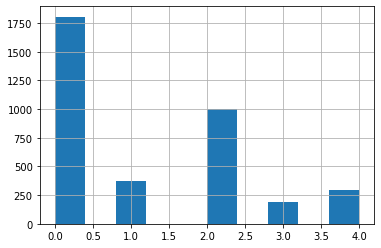

In [4]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

### Displaying some Sample Images

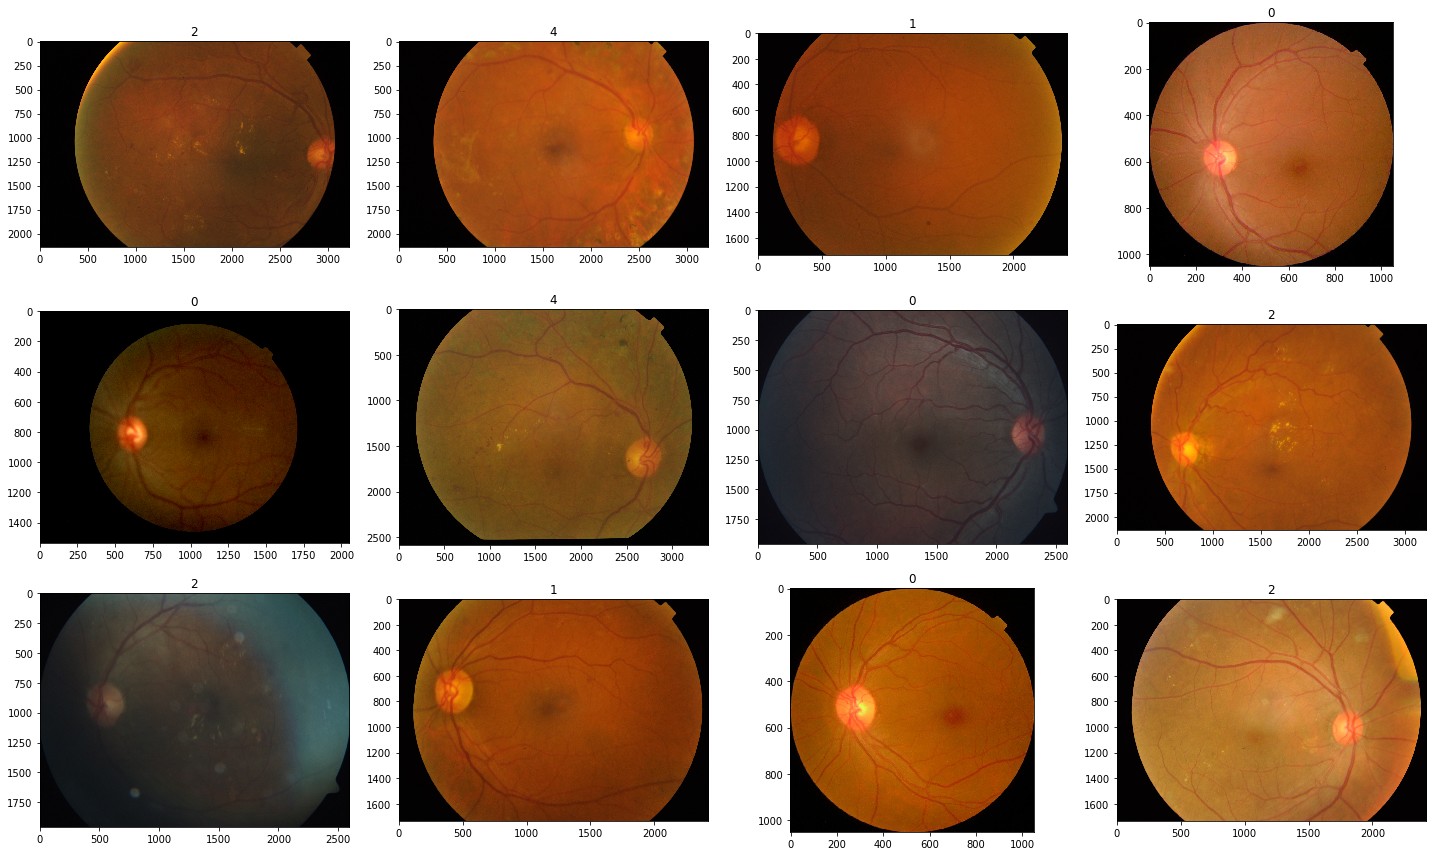

In [5]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'data/blindness/train/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# Resize Images

Rsize the images to 224x224, then create a single numpy array to hold the data.

In [6]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [7]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'data/blindness/train/{image_id}.png'
    )

100%|██████████| 3662/3662 [06:50<00:00,  9.16it/s]


In [8]:
N = test_df.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
        f'data/blindness/test/{image_id}.png'
    )

100%|██████████| 1928/1928 [01:28<00:00, 19.57it/s]


In [9]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(3662, 224, 224, 3)
(3662, 5)
(1928, 224, 224, 3)


## Creating multilabels

For more details, please check out [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets).

In [10]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


Now we can split it into a training and validation set.

In [11]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi, 
    test_size=0.15, 
    random_state=2019
)

# Mixup & Data Generator

In [12]:
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [13]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE)
# Using Mixup
mixup_generator = MixupGenerator(x_train, y_train, batch_size=BATCH_SIZE, alpha=0.2, datagen=create_datagen())()

# Quadratic Weighted Kappa

Quadratic Weighted Kappa (QWK, the greek letter $\kappa$), also known as Cohen's Kappa, is the official evaluation metric. For our kernel, we will use a custom callback to monitor the score, and plot it at the end.

### What is Cohen Kappa?

According to the [wikipedia article](https://en.wikipedia.org/wiki/Cohen%27s_kappa), we have
> The definition of $\kappa$ is:
> $$\kappa \equiv \frac{p_o - p_e}{1 - p_e}$$
> where $p_o$ is the relative observed agreement among raters (identical to accuracy), and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly seeing each category.

### How is it computed?

Let's take the example of a binary classification problem. Say we have:

In [14]:
true_labels = np.array([1, 0, 1, 1, 0, 1])
pred_labels = np.array([1, 0, 0, 0, 0, 1])

We can construct the following table:

| true | pred | agreement      |
|------|------|----------------|
| 1    | 1    | true positive  |
| 0    | 0    | true negative  |
| 1    | 0    | false negative |
| 1    | 0    | false negative |
| 0    | 0    | true negative  |
| 1    | 1    | true positive  |


Then the "observed proportionate agreement" is calculated exactly the same way as accuracy:

$$
p_o = acc = \frac{tp + tn}{all} = {2 + 2}{6} = 0.66
$$

This can be confirmed using scikit-learn:

In [ ]:
accuracy_score(true_labels, pred_labels)

Additionally, we also need to compute `p_e`:

$$p_{yes} = \frac{tp + fp}{all} \frac{tp + fn}{all} = \frac{2}{6} \frac{4}{6} = 0.222$$

$$p_{no} = \frac{fn + tn}{all} \frac{fp + tn}{all} = \frac{4}{6} \frac{2}{6} = 0.222$$

$$p_{e} = p_{yes} + p_{no} = 0.222 + 0.222 = 0.444$$

Finally,

$$
\kappa = \frac{p_o - p_e}{1-p_e} = \frac{0.666 - 0.444}{1 - 0.444} = 0.4
$$

Let's verify with scikit-learn:

In [15]:
cohen_kappa_score(true_labels, pred_labels)

0.3999999999999999

### What is the weighted kappa?

The wikipedia page offer a very concise explanation: 
> The weighted kappa allows disagreements to be weighted differently and is especially useful when **codes are ordered**. Three matrices are involved, the matrix of observed scores, the matrix of expected scores based on chance agreement, and the weight matrix. Weight matrix cells located on the diagonal (upper-left to bottom-right) represent agreement and thus contain zeros. Off-diagonal cells contain weights indicating the seriousness of that disagreement.

Simply put, if two scores disagree, then the penalty will depend on how far they are apart. That means that our score will be higher if (a) the real value is 4 but the model predicts a 3, and the score will be lower if (b) the model instead predicts a 0. Intuitively, a model that predicts a severe retinopathy (3) when it is in reality a proliferative retinopathy (4) is probably better than a model that predicts a mild retinopathy (1).

### Creating keras callback for QWK

In [16]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

# Model: DenseNet-121

In [17]:
DENSENET_121_WEIGHTS_PATH_NO_TOP = (r'https://github.com/titu1994/DenseNet/releases/'
r'download/v3.0/DenseNet-BC-121-32-no-top.h5')
densenet = DenseNet121(
    weights=get_file('DenseNet-BC-121-32-no-top.h5',
                                        DENSENET_121_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models',
                                        md5_hash='55e62a6358af8a0af0eedf399b5aea99'),
    include_top=False,
    input_shape=(224,224,3)
)

W0707 17:17:30.101724 139777646634816 deprecation_wrapper.py:119] From /home/vadim/anaconda3/envs/fastai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0707 17:17:30.222907 139777646634816 deprecation_wrapper.py:119] From /home/vadim/anaconda3/envs/fastai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0707 17:17:30.283133 139777646634816 deprecation_wrapper.py:119] From /home/vadim/anaconda3/envs/fastai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0707 17:17:30.336824 139777646634816 deprecation_wrapper.py:119] From /home/vadim/anaconda3/envs/fastai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprec

In [18]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [19]:
model = build_model()
model.summary()

W0707 17:18:10.303989 139777646634816 deprecation.py:506] From /home/vadim/anaconda3/envs/fastai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0707 17:18:10.330881 139777646634816 deprecation_wrapper.py:119] From /home/vadim/anaconda3/envs/fastai/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0707 17:18:10.336957 139777646634816 deprecation.py:323] From /home/vadim/anaconda3/envs/fastai/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, wh

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


# Training & Evaluation

In [20]:
kappa_metrics = Metrics()

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics]
)

Epoch 1/15
98/97 [==============================] - 52s 526ms/step - loss: 0.4080 - acc: 0.8133 - val_loss: 0.3148 - val_acc: 0.8804 - loss: 0.4480 -  - ETA: 5s - loss: 0.4289 - 
val_kappa: 0.8075
Validation Kappa has improved. Saving model.
Epoch 2/15
98/97 [==============================] - 21s 214ms/step - loss: 0.2043 - acc: 0.9260 - val_loss: 0.1570 - val_acc: 0.9440 - loss: 0.2021 - acc 
val_kappa: 0.8555
Validation Kappa has improved. Saving model.
Epoch 3/15
98/97 [==============================] - 21s 214ms/step - loss: 0.1695 - acc: 0.9365 - val_loss: 0.1420 - val_acc: 0.9502
val_kappa: 0.9055
Validation Kappa has improved. Saving model.
Epoch 4/15
98/97 [==============================] - 21s 214ms/step - loss: 0.1440 - acc: 0.9453 - val_loss: 0.1168 - val_acc: 0.9538
val_kappa: 0.8924
Epoch 5/15
98/97 [==============================] - 21s 217ms/step - loss: 0.1285 - acc: 0.9528 - val_loss: 0.1009 - val_acc: 0.9615 1s - loss: 0.1294 - acc
val_kappa: 0.9092
Validation Kappa h

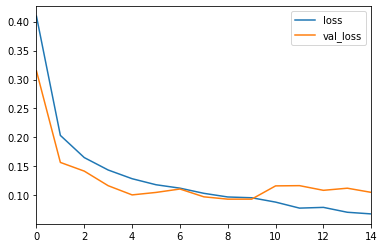

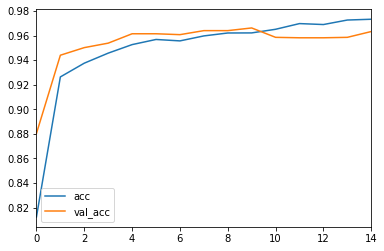

In [21]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

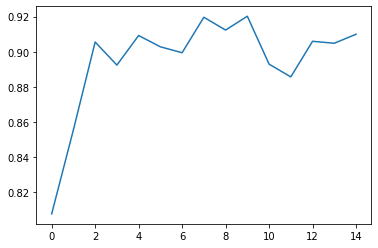

In [22]:
plt.plot(kappa_metrics.val_kappas)

## Find best threshold

In [23]:
model.load_weights('model.h5')
y_val_pred = model.predict(x_val)

def compute_score_inv(threshold):
    y1 = y_val_pred > threshold
    y1 = y1.astype(int).sum(axis=1) - 1
    y2 = y_val.sum(axis=1) - 1
    score = cohen_kappa_score(y1, y2, weights='quadratic')
    
    return 1 - score

simplex = scipy.optimize.minimize(
    compute_score_inv, 0.5, method='nelder-mead'
)

best_threshold = simplex['x'][0]